## load data

In [1]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!






/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [2]:
img, label = mnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  5
tensor([[[-0.9922,  0.2078,  0.9843, -0.2941, -1.0000],
         [-1.0000,  0.0902,  0.9843,  0.4902, -0.9843],
         [-1.0000, -0.9137,  0.4902,  0.9843, -0.4510],
         [-1.0000, -1.0000, -0.7255,  0.8902,  0.7647],
         [-1.0000, -1.0000, -1.0000, -0.3647,  0.8824]]])


(tensor(-1.), tensor(1.))

In [7]:
def denorm(x):
    out = (x+1) / 2
    # clamp func is to restrict range of value
    return out.clamp(0,1)

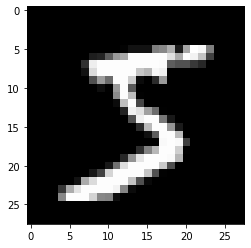

In [10]:
import matplotlib.pyplot as plt

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')

In [11]:
from torch.utils.data import  DataLoader

batch_size = 128
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first
torch.Size([128, 1, 28, 28])


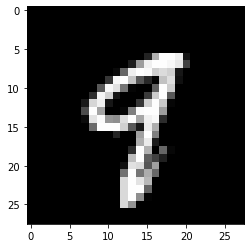

In [12]:
for imgs, labels in data_loader:
    print('first')
    print(imgs.shape)
    plt.imshow(imgs[0][0],cmap='gray')
    break

In [13]:
# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
device

device(type='cpu')

## Discriminator Network

In [16]:
img_size = 28*28
hidden_size = 256

In [19]:
import torch.nn as nn
# in this example we'll use three linear layers as discriminator
# in general, we can use CNN for the discriminator
# leakyReLU makes the grads from the discriminator flows stronger into generator
D = nn.Sequential(
    nn.Linear(img_size, hidden_size),
    nn.LeakyReLU(.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

## Generator Network

In [23]:
latent_size = 64

In [25]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, img_size),
    nn.Tanh()
)

In [54]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

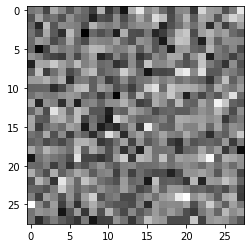

In [55]:
plt.imshow(gen_imgs[0], cmap='gray')

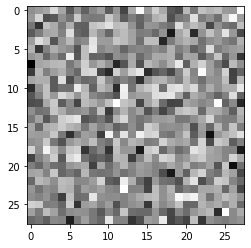

In [56]:
plt.imshow(gen_imgs[1], cmap='gray')

In [57]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

## Discriminator Training

In [59]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=3e-4)